In [1]:
import numpy as np
import pandas as pd

import researchpy as rp
import scipy.stats as stats
import category_encoders as ce

import seaborn as sb
import matplotlib.pyplot as plt

import sklearn.base as skbase
import sklearn.metrics as smet
import sklearn.pipeline as skpipe
import sklearn.preprocessing as skpre
import sklearn.linear_model as lm
import sklearn.model_selection as ms

In [2]:
brfss_large = pd.read_csv('/home/kylier/python/python-ds/BRFSS_Clean_Combo.csv')

In [3]:
brfss_small = pd.read_csv('/home/kylier/python/python-ds/BRFSS_SAMPLE_WEIGHTED.csv')

In [4]:
# MODEL 1: LOGISTIC REGRESSION
# ----------------------------

# define possible predictors, retain y = COMORB_1.
# Use small sample for now.
brfss1 = pd.DataFrame(brfss_small,
                      columns=["ID", "YEAR", "L_EMPLOY1", "L_AGE_G", "L_BMI5CAT", "L_SEX", "B_SMOKER", "B_HLTHPLN",
                               "B_COUPLED", "L_INCOMG", "L_EDUCAG", "SEX", "_AGE_G", "EMPLOY1", "_INCOMG",
                              "_EDUCAG", "_BMI5CAT", "L_STATEAB", "COMORB_1"])



In [5]:
brfss1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         12000 non-null  int64  
 1   YEAR       12000 non-null  int64  
 2   L_EMPLOY1  11950 non-null  object 
 3   L_AGE_G    0 non-null      float64
 4   L_BMI5CAT  10961 non-null  object 
 5   L_SEX      11989 non-null  object 
 6   B_SMOKER   12000 non-null  int64  
 7   B_HLTHPLN  12000 non-null  int64  
 8   B_COUPLED  12000 non-null  int64  
 9   L_INCOMG   12000 non-null  object 
 10  L_EDUCAG   12000 non-null  object 
 11  SEX        11989 non-null  float64
 12  _AGE_G     0 non-null      float64
 13  EMPLOY1    11950 non-null  float64
 14  _INCOMG    12000 non-null  int64  
 15  _EDUCAG    12000 non-null  int64  
 16  _BMI5CAT   10961 non-null  float64
 17  L_STATEAB  12000 non-null  object 
 18  COMORB_1   12000 non-null  int64  
dtypes: float64(5), int64(8), object(6)
memory usag

In [9]:
# Load 'enrich.py' functions
import importlib.util
spec = importlib.util.spec_from_file_location("enrich", "/home/kylier/python/python-ds/enrich.py")
enrich = importlib.util.module_from_spec(spec)
spec.loader.exec_module(enrich)

In [10]:
# Load 'learn.py' functions
import importlib.util
spec = importlib.util.spec_from_file_location("learn", "/home/kylier/python/python-ds/learn.py")
learn = importlib.util.module_from_spec(spec)
spec.loader.exec_module(learn)

In [11]:
brfss1.isnull().sum()

ID               0
YEAR             0
L_EMPLOY1       50
L_AGE_G      12000
L_BMI5CAT     1039
L_SEX           11
B_SMOKER         0
B_HLTHPLN        0
B_COUPLED        0
L_INCOMG         0
L_EDUCAG         0
SEX             11
_AGE_G       12000
EMPLOY1         50
_INCOMG          0
_EDUCAG          0
_BMI5CAT      1039
L_STATEAB        0
COMORB_1         0
dtype: int64

In [12]:
brfss1[brfss1 == 9].sum(axis=0)

ID               0.0
YEAR             0.0
L_EMPLOY1        0.0
L_AGE_G          0.0
L_BMI5CAT        0.0
L_SEX            0.0
B_SMOKER         0.0
B_HLTHPLN        0.0
B_COUPLED        0.0
L_INCOMG         0.0
L_EDUCAG         0.0
SEX              0.0
_AGE_G           0.0
EMPLOY1        999.0
_INCOMG      18477.0
_EDUCAG        459.0
_BMI5CAT         0.0
L_STATEAB        0.0
COMORB_1         0.0
dtype: float64

In [13]:
# translate associated columns' null, NaN, blank and 9 values for non-binary categorical variables to zero
brfss1 = enrich.replaceCVs(brfss1, ["SEX", "_AGE_G", "EMPLOY1", "_INCOMG", "_EDUCAG", "_BMI5CAT"], 
                           [np.nan, 9, "", " "], 0)

In [14]:
brfss1.isnull().sum()

ID               0
YEAR             0
L_EMPLOY1       50
L_AGE_G      12000
L_BMI5CAT     1039
L_SEX           11
B_SMOKER         0
B_HLTHPLN        0
B_COUPLED        0
L_INCOMG         0
L_EDUCAG         0
SEX              0
_AGE_G           0
EMPLOY1          0
_INCOMG          0
_EDUCAG          0
_BMI5CAT         0
L_STATEAB        0
COMORB_1         0
dtype: int64

In [15]:
brfss1[brfss1 == 9].sum(axis=0)

ID           0.0
YEAR         0.0
L_EMPLOY1    0.0
L_AGE_G      0.0
L_BMI5CAT    0.0
L_SEX        0.0
B_SMOKER     0.0
B_HLTHPLN    0.0
B_COUPLED    0.0
L_INCOMG     0.0
L_EDUCAG     0.0
SEX          0.0
_AGE_G       0.0
EMPLOY1      0.0
_INCOMG      0.0
_EDUCAG      0.0
_BMI5CAT     0.0
L_STATEAB    0.0
COMORB_1     0.0
dtype: float64

In [24]:
brfss1["L_EMPLOY1"].unique()

array(['Employed', 'Homemaker', 'Unable', 'Retired', 'Self-Employed',
       'Out of Work 1 yr+', nan, 'Student', 'Out of Work <1 yr'],
      dtype=object)

In [27]:
brfss1["L_AGE_G"].unique()

KeyError: ' L_AGE_G'

In [19]:
# Based on prior JMP analysis, one hot encode the following: L_SEX, L_AGE_G, L_INCOMG, L_BMI5CAT, L_EMPLOY1 and L_EDUCAG
brfss1 = enrich.one_hot_encode(brfss1, "L_SEX")
brfss1 = enrich.one_hot_encode(brfss1, "L_AGE_G")
brfss1 = enrich.one_hot_encode(brfss1, "L_INCOMG")
brfss1 = enrich.one_hot_encode(brfss1, "L_BMI5CAT")
brfss1 = enrich.one_hot_encode(brfss1, "L_EMPLOY1")
brfss1 = enrich.one_hot_encode(brfss1, "L_EDUCAG")

ValueError: columns overlap but no suffix specified: Index([' '], dtype='object')

In [12]:
brfss2.isnull().sum()

ID               0
YEAR             0
B_SMOKER         0
B_HLTHPLN        0
B_COUPLED        0
SEX              0
_AGE_G           0
EMPLOY1          0
_INCOMG          0
_EDUCAG          0
_BMI5CAT         0
COMORB_1         0
FEMALE           0
MALE             0
18-24            0
25-34            0
35-44            0
45-54            0
55-64            0
65+              0
$15-25K          0
$25-35K          0
$35-50K          0
$50K+            0
<$15K            0
NORMAL WEIGHT    0
OBESE            0
OVER WEIGHT      0
UNDER WEIGHT     0
EMPLOYED         0
HOMEMAKER        0
OOW 1 yr+        0
OOW <1 yr        0
RETIRED          0
SELF-EMPLOYED    0
STUDENT          0
UNABLE           0
< HS             0
COLLEGE GRAD     0
HS GRAD          0
SOME COLLEGE     0
dtype: int64

In [13]:
# Cast all to int64
brfss2 = brfss2.astype("int64")

In [14]:
# Drop the columns with the least predictive power
brfss2 = brfss2.drop(["SOME COLLEGE", "OOW 1 yr+", "55-64", "HS GRAD", "$25-35K", "UNDER WEIGHT", "$35-50K",
                      "OOW <1 yr", "HOMEMAKER", "STUDENT", "45-54"], axis=1)

# Reindex
brfss2.reset_index(drop=True, inplace=True)

In [15]:
# Stratified Shuffle Split based on the outcome variable
brfss_train, brfss_test = enrich.split_train_test_strat(brfss2, "COMORB_1", 1, 0.5, 42)

# Another, to try to reduce the size of the training data for improved performance
brfss_train.reset_index(drop=True, inplace=True)
brfss_train, brfss_test = enrich.split_train_test_strat(brfss_train, "COMORB_1", 1, 0.5, 42)

In [16]:
brfss_x, brfss_y, test_x, test_y = enrich.prepareXYSets(brfss_train, brfss_test, "COMORB_1")

In [28]:
# Trying to use SGD for Logistic Regression Model with large dataset

# Attempt a base model, for comparison
logModel = lm.SGDClassifier(loss="log", penalty="l2", max_iter=5000, early_stopping=True)

In [29]:
logModel.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 5000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [30]:
# Cross Validate using 10 iterations 
# NOTE: needed 5000 max_iter to reach convergence, allowing early_stopping helped to increase performance
# Is that a good idea? (Not sure.)
scores = ms.cross_val_score(logModel, brfss_x, brfss_y, cv = 10)
print("Initial accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Initial accuracy: 0.51 (+/- 0.12)


In [32]:
# Attempt to tune -
# Do not change loss type. 
# Performed alright with cv=3 (Adequate?)
params = {
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "penalty": ["l2", "l1", "elasticnet", "none"],
        "max_iter": [2500, 5000],
        "early_stopping": [True]
}

logModel2 = lm.SGDClassifier(loss="log")
grid = ms.GridSearchCV(logModel2, param_grid=params, cv=3)
grid.fit(brfss_x, brfss_y)
print("Params: ")
print(grid.best_params_)

Params: 
{'alpha': 0.0001, 'early_stopping': True, 'max_iter': 2500, 'penalty': 'l2'}


In [34]:
# Params result - alpha: 0.0001, penalty: "l2"; max_iter: 2500
logModel3 = lm.SGDClassifier(loss="log", penalty="l2", alpha=0.0001, max_iter=2500, early_stopping=True)
logModel3.fit(brfss_x, brfss_y)

SGDClassifier(early_stopping=True, loss='log', max_iter=2500)

In [36]:
yPredicted = logModel3.predict(test_x)
print('Accuracy: {:.2f}'.format(smet.accuracy_score(test_y, yPredicted)))

Accuracy: 0.56


In [40]:
# Load 'learn.py' functions
spec = importlib.util.spec_from_file_location("learn", "/home/kylier/python/python-ds/learn.py")
learn = importlib.util.module_from_spec(spec)
spec.loader.exec_module(learn)

Confusion Matrix: 
Row 1 - true negatives, false positives
Row 2 - false negatives, true positives
[[149848      0]
 [117219      0]]


              precision    recall  f1-score   support

           0       0.56      1.00      0.72    149848
           1       0.00      0.00      0.00    117219

    accuracy                           0.56    267067
   macro avg       0.28      0.50      0.36    267067
weighted avg       0.31      0.56      0.40    267067





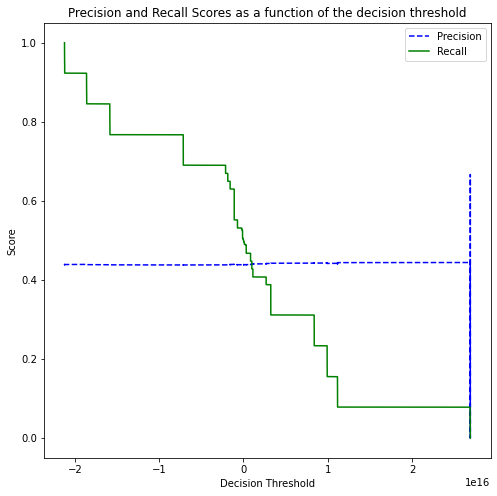

No handles with labels found to put in legend.


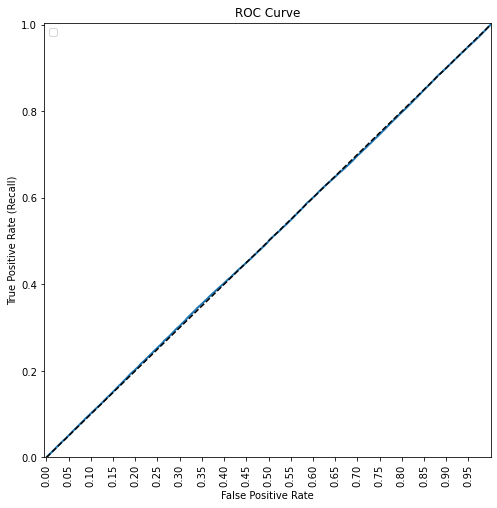

AUC Score: 
0.5005008062976161




In [41]:
# Show all metrics - wow, this model is awful.  I guess changing parameters was a stupid idea. :(
learn.showMetrics(logModel3, brfss_x, brfss_y, test_y, yPredicted, cv=10)